## Pytorch - Capsule Network for image classification of x-ray pneunomia images 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Hyperparameters

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32

## Data transforms

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Data loaders

In [4]:

train_dataset = datasets.ImageFolder('./data/train/', transform=train_transform)
val_dataset = datasets.ImageFolder('./data/val/', transform=val_transform)
test_dataset = datasets.ImageFolder('./data/test/', transform=val_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Squash function and Capsule Layer 


In [5]:
# Squash activation function used in capsule networks to ensure vector lengths are between 0 and 1
def squash(x, dim=-1):
    # Calculate squared norm along specified dimension
    squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
    # Calculate scaling factor that squashes vectors
    scale = squared_norm / (1 + squared_norm)
    # Scale the vectors and normalize
    return scale * x / torch.sqrt(squared_norm + 1e-8)

class CapsuleLayer(nn.Module):
    """
    Implementation of a capsule layer that performs dynamic routing between capsules
    """
    def __init__(self, num_capsules, in_channels, out_channels, routing_iters=3):
        super().__init__()
        self.num_capsules = num_capsules  # Number of output capsules
        self.routing_iters = routing_iters  # Number of routing iterations
        self.in_channels = in_channels  # Input capsule dimension
        self.out_channels = out_channels  # Output capsule dimension
        # Transformation matrices for converting input capsules to output capsules
        self.W = nn.Parameter(torch.randn(1, num_capsules, in_channels, out_channels) * 0.01)

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape input for matrix multiplication
        x = x.permute(0, 2, 1).unsqueeze(1)
        # Expand transformation matrix for batch processing
        W = self.W.expand(batch_size, self.num_capsules, self.in_channels, self.out_channels)
        # Transform input capsules
        u_hat = torch.matmul(x, W)
        # Initialize routing logits
        b = torch.zeros(batch_size, self.num_capsules, x.size(2), 1).to(x.device)
        
        # Dynamic routing algorithm
        for i in range(self.routing_iters):
            # Convert logits to coupling coefficients via softmax
            c = F.softmax(b, dim=1)
            # Weight prediction vectors by coupling coefficients
            s = (c * u_hat).sum(dim=2)
            # Apply squashing non-linearity
            v = squash(s, dim=-1)
            
            # Update routing logits (except for last iteration)
            if i < self.routing_iters - 1:
                v_expanded = v.unsqueeze(2)
                # Calculate agreement between predictions and output
                agreement = torch.matmul(u_hat, v_expanded.transpose(-1, -2))
                b = b + agreement

        return v


## Capsule Network - MobileNetV3 backbone

In [6]:
class CapsuleNetwork(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super().__init__()
        
        # MobileNetV3 backbone
        backbone = models.mobilenet_v3_large(weights='DEFAULT')
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        
        # Freeze backbone layers
        for param in self.features.parameters():
            param.requires_grad = False
            
        # Reduction layer with regularization
        self.conv = nn.Sequential(
            nn.Conv2d(960, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate)
        )
        
        # Primary capsules
        self.primary_capsules = CapsuleLayer(
            num_capsules=16,
            in_channels=256,
            out_channels=8
        )
        
        # Digit capsules
        self.digit_capsules = CapsuleLayer(
            num_capsules=num_classes,
            in_channels=8,
            out_channels=16
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.primary_capsules(x)
        x = x.transpose(1, 2)
        x = self.digit_capsules(x)
        classes = torch.sqrt((x ** 2).sum(dim=-1))
        return classes

## Margin loss function

In [7]:
def margin_loss(predictions, labels, lambda_=0.5, m_plus=0.9, m_minus=0.1):
    positive_cost = labels * torch.clamp(m_plus - predictions, min=0) ** 2
    negative_cost = lambda_ * (1 - labels) * torch.clamp(predictions - m_minus, min=0) ** 2
    return (positive_cost + negative_cost).sum(dim=1).mean()

## Training setup

In [8]:
model = CapsuleNetwork(num_classes=2, dropout_rate=0.5).cuda()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
scaler = GradScaler()

## Training loop

In [9]:

def train_epoch(model, train_loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Create progress bar
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        target = F.one_hot(target, num_classes=2).float()
        
        # Mixed precision training with simplified syntax
        with autocast():
            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = margin_loss(output, target)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target.argmax(dim=1)).sum().item()
        total += target.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.4f}'
        })
    
    return total_loss / len(train_loader), correct / total


## Validation function 

In [10]:
@torch.no_grad()  
def validate(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc='Validating', leave=False)
    
    for data, target in pbar:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
        target = F.one_hot(target, num_classes=2).float()
        
        with autocast():
            output = model(data)
            loss = margin_loss(output, target)
        
        val_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target.argmax(dim=1)).sum().item()
        total += target.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.4f}'
        })
    
    return val_loss / len(val_loader), correct / total


## Training loop with progress tracking

In [11]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 30
best_val_acc = 0

epoch_pbar = tqdm(range(num_epochs), desc='Epochs')
for epoch in epoch_pbar:
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        }, 'best_model.pth')
    
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.4f}',
        'val_loss': f'{val_loss:.4f}',
        'val_acc': f'{val_acc:.4f}',
        'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
    })


Epochs: 100%|██████████| 30/30 [13:42<00:00, 27.41s/it, train_loss=0.0375, train_acc=0.9440, val_loss=0.1050, val_acc=0.8750, lr=0.000000]


## Plotting learning curves

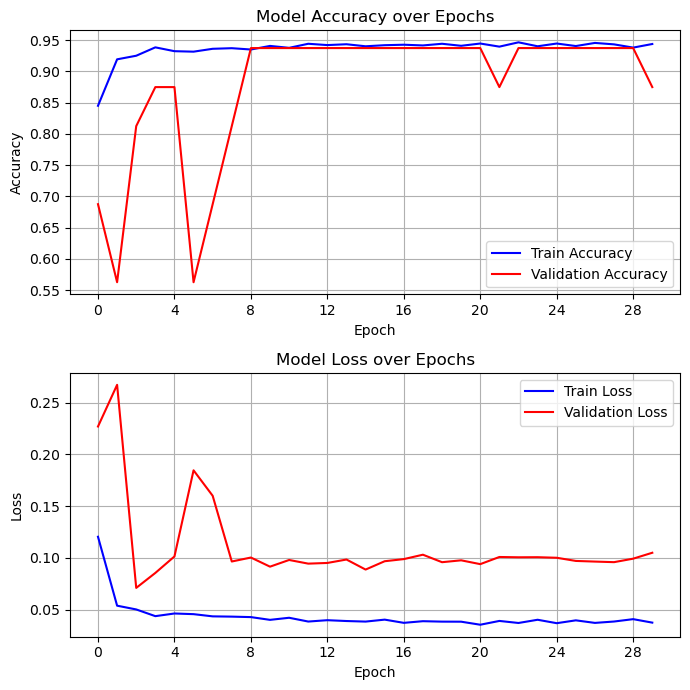


Best validation accuracy: 0.9375


In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

# Plot accuracy
ax1.plot(train_accs, label='Train Accuracy', color='blue')
ax1.plot(val_accs, label='Validation Accuracy', color='red')
ax1.set_title('Model Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot loss
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Validation Loss', color='red')
ax2.set_title('Model Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# Print best validation accuracy
print(f'\nBest validation accuracy: {best_val_acc:.4f}')

## Load best model and evaluate on test set

In [13]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
test_loss, test_acc = validate(model, test_loader)
print(f'Test accuracy: {test_acc:.4f}')


Test accuracy: 0.8638
